In [35]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
from torch.utils.data import ConcatDataset, DataLoader, Dataset
import numpy as np
from nptyping import Float32, NDArray, Number, Shape, UInt
from transformers import ViTModel
import pytorch_lightning as pl
import math
from torch.autograd import Variable

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

ModuleNotFoundError: No module named 'torch'

In [36]:
class SignedDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [37]:
class ViT_FeatureExtractor(pl.LightningModule):
	def __init__(
		self,
		nb_classes: int = 10,
		batch_size: int = 2,
		seq_size: int = 2,
	):
		super().__init__()
		self.pretrained_vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
		self.pretrained_vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
		self.pretrained_vit.eval()
		self.batch_size = batch_size
		self.seq_size = seq_size

		self.batch_size = batch_size
		self.seq_size = seq_size
		self.pretrained_vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
		self.pretrained_vit.eval()
		self.conv_1d_1 = torch.nn.Conv1d(
			in_channels=197,
			out_channels=64,
			kernel_size=3,
		)
		self.layer_1_relu = nn.ReLU()
		self.conv_1d_2 = torch.nn.Conv1d(
			in_channels=64,
			out_channels=nb_classes, # <-- i/o 1
			kernel_size=3,
		)
		self.layer_2_relu = nn.ReLU()

	def vit_extract_features(self, x):
		# print("---VIT EXTRACT FEATURES---")
		with torch.no_grad():
			outputs = self.pretrained_vit(pixel_values=x)
			vit_feat = outputs.last_hidden_state
			vit_feat = torch.flatten(vit_feat, start_dim=1)
			b, f = vit_feat.size()
			vit_feat = torch.reshape(vit_feat, (self.batch_size, self.seq_size, f))
		return vit_feat
	
	def forward(
		self,
		vit_feat, 
	) -> NDArray[Shape["* batch, * vocab size"], Float32]:
		# print("---VIT FORWARD---")
		x = self.conv_1d_1(vit_feat)
		x = self.layer_1_relu(x)
		x = self.conv_1d_2(x)
		x = self.layer_2_relu(x)
		return x


In [38]:
class GRU_Translator(pl.LightningModule):
	def __init__(
		self,
		nb_classes,
		H_input_size: int = 151296,
		H_output_size: int = 10,
		num_layers: int = 1,
		dropout: int = 0,
	):
		# print("---GRU INIT---")
		super().__init__()

	
		self.save_hyperparameters()
		self.vocabulary_size = nb_classes
		self.layer_gru = nn.GRU(
			input_size=self.hparams.H_input_size,
			hidden_size=self.hparams.nb_classes,
			num_layers=self.hparams.num_layers,
			batch_first=True,
			dropout=self.hparams.dropout
		)
		
		self.layer_1_dense = nn.Linear(self.hparams.nb_classes, int(self.hparams.nb_classes / 2))
		self.layer_2_dense = nn.Linear(int(self.hparams.nb_classes / 2), self.hparams.nb_classes)

		self.layer_1_relu = nn.ReLU()
		# self.layer_2_dense = nn.Linear(self.hparams.H_output_size, self.vocabulary_size)
		self.layer_leaky_relu = nn.LeakyReLU()
		self.softmax = nn.Softmax(dim=2) # <-- i/o dim=2

	def forward(self, X):
		X, _ = self.layer_gru(X)
		X = self.layer_1_dense(X)
		X = self.layer_1_relu(X)
		X = self.layer_2_dense(X)
		X = self.softmax(X)
		return X


In [39]:
class BaseSquareNet(pl.LightningModule):
	def __init__(
		self,
		batch_size: int = 1,
		seq_size: int = 1,
		nb_classes: int = 10,
		h_in: int = 10,
	):
		super().__init__()
		self.save_hyperparameters()

		self.batch_size = batch_size
		self.nb_seq_sizebatch = seq_size
		self.image_feature_extractr = ViT_FeatureExtractor(
			nb_classes=nb_classes, 
			batch_size=batch_size, 
			seq_size=seq_size
		)
		self.recurrent_translator = GRU_Translator(
			nb_classes = nb_classes,
			H_input_size=h_in,
			num_layers=1,
			dropout=0
		)

	def forward(
		self, x: NDArray[Shape["* batch, 224, 224, 3"], Float32]
	) -> NDArray[Shape["* batch, * vocab size"], Float32]:
		# print(f"{x.shape=}")
		x = self.recurrent_translator(x)
		return x

In [40]:
# Hyperparameters
nb_classes=10
seq_size = 2
batch_size = 2
learning_rate = 1e-4
h_in = 151_296


In [41]:
x = torch.rand((batch_size * seq_size, 3, 224, 224))
y = torch.randint(0, nb_classes, (batch_size, seq_size))

# print(f"{y.size()=}")
# print(f"{y=}")


In [42]:
from tqdm import tqdm 

# Models
# vit_feat = model.image_feature_extractr.vit_extract_features(x)

# dataset = SignedDataset(vit_feat, y)
model = BaseSquareNet(batch_size=batch_size, seq_size=seq_size, nb_classes=nb_classes, h_in=h_in)
vit_feat = model.image_feature_extractr.vit_extract_features(x)
dataset = SignedDataset(vit_feat, y)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
	# lr = 10 ** (- e_lr / 10)

loss_fn = torch.nn.CrossEntropyLoss()

def train(train_loader, model, loss_fn, learning_rate, epochs=100):
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
	losses = []
	idx = 0
	for epoch in tqdm(range(epochs)):
		for batch_idx, (X, y) in enumerate(train_loader):
			# print(idx)
			pred = model(X)
			# print(f"{pred.shape=}")
			pred = pred.permute(0, 2, 1)
			loss = loss_fn(pred, y)
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()

			# if epoch % 10 == 0:
			# 	print(f'[{epoch = }] loss: {loss}')
			idx += 1
			losses.append(float(loss.detach().numpy()))
	return losses

100%|██████████| 1000/1000 [00:35<00:00, 28.51it/s]


For lr = 0.001, min(losses) = 1.9294836521148682


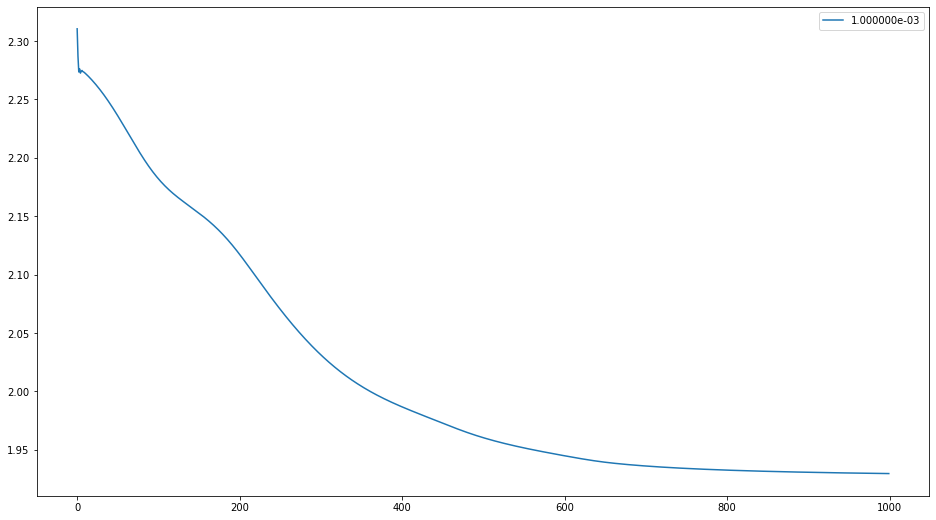

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
torch.manual_seed(6)

for lr in [5e-4]:
	# lr = 10 ** (- e_lr / 10)
	# model = GRU(input_size=h_in, hidden_size=5, output_size=nb_classes, num_layers=1, bias=0)
	model = BaseSquareNet(nb_classes=nb_classes, seq_size=seq_size, batch_size=batch_size, h_in=h_in)
	losses = train(dataloader, model, loss_fn, learning_rate=lr, epochs=int(3e3))
	print(f"For {lr = }, {min(losses) = }")
	plt.plot(losses, label=f"{lr:e}")
leg = plt.legend(loc='best')
plt.show()